# Sankey diagram data generation

**Libraries**

In [1]:
import pandas as pd
import json
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
df = pd.read_csv('../data/SpeedDating.csv', encoding='latin1')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [3]:
print(f" # unique participants : {df['iid'].nunique()}")

 # unique participants : 551


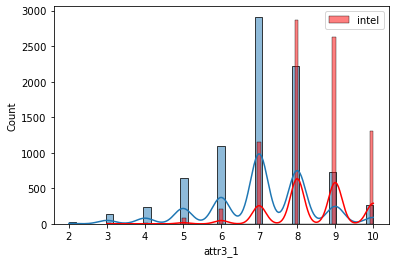

In [4]:
import seaborn as sns
sns.histplot(df, x='attr3_1', kde=True);
sns.histplot(df, x='intel3_1', kde=True, color='r', label='intel')
plt.legend();

**Correlation between participant's and partner's ratings of interest**

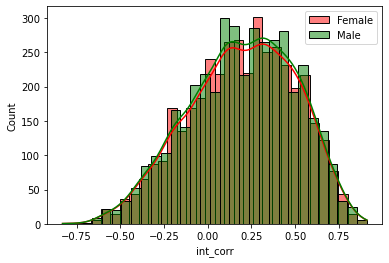

In [5]:
sns.histplot(df[df['gender']==0], x='int_corr', kde=True, label='Female', color='red')
sns.histplot(df[df['gender']==1], x='int_corr', kde=True, label='Male', color='green')
plt.legend();

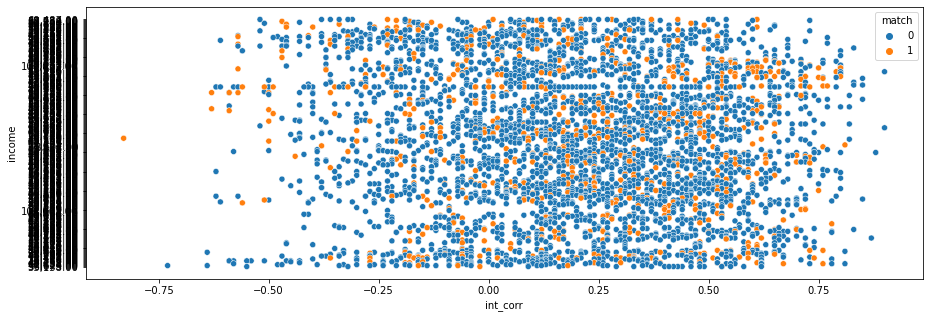

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df_scatter = df[['iid', 'income', 'int_corr', 'match']].dropna()
sns.scatterplot(data=df_scatter, x='int_corr', y='income', hue='match');

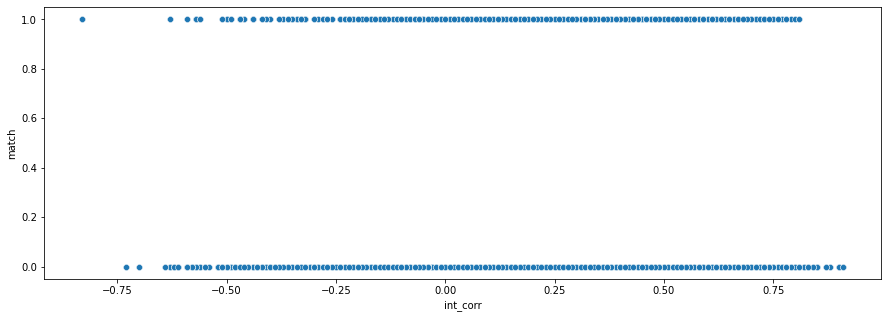

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df_scatter = df[['iid', 'int_corr', 'match']].dropna()
sns.scatterplot(data=df_scatter, x='int_corr', y='match');

**Income distribution by gender**

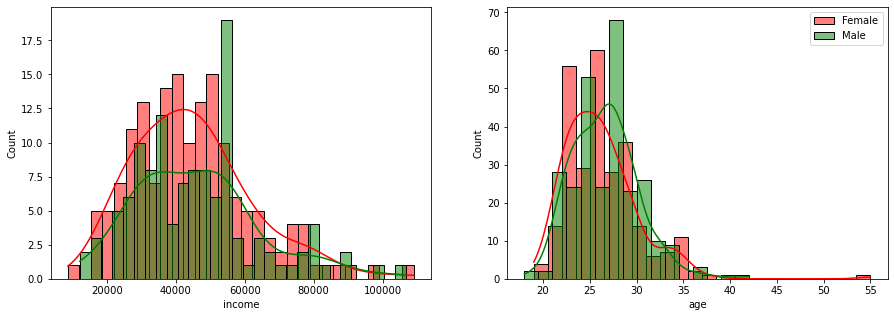

In [8]:
df_income = df[['iid', 'gender', 'income']].drop_duplicates().dropna()
df_income['income'] = df['income'].apply(lambda x: (str(x).replace(',', '')[:-3]))
df_income['income'] = pd.to_numeric(df_income['income'])

df_age = df[['iid', 'gender', 'age']].drop_duplicates().dropna()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_income[df_income['gender']==0], x='income', kde=True, label='Female', color='red', ax=ax[0], bins=30)
sns.histplot(df_income[df_income['gender']==1], x='income', kde=True, label='Male', color='green', ax=ax[0], bins=30)

sns.histplot(df_age[df_age['gender']==0], x='age', kde=True, label='Female', color='red', ax=ax[1])
sns.histplot(df_age[df_age['gender']==1], x='age', kde=True, label='Male', color='green', ax=ax[1])

plt.legend();

**Attractiveness vs matches**

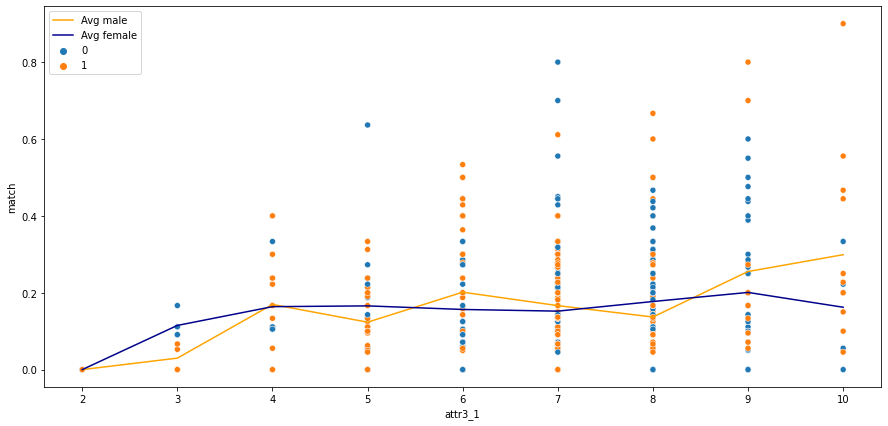

In [9]:
def compute_perct(x):
    res = sum(x.values) / len(x.values)
    return res

df_att_match = df[['iid', 'gender', 'attr3_1', 'match']].dropna()
df_att_match = pd.DataFrame(df_att_match.groupby(['iid', 'gender', 'attr3_1'])['match'] \
                            .apply(lambda x: compute_perct(x))) \
                            .reset_index()

# Compute means for each group
df_att_match_avg = df_att_match.groupby(['gender', 'attr3_1']).mean('match').reset_index()
avg_male = df_att_match_avg[df_att_match_avg['gender']==1]['match'].values
avg_female = df_att_match_avg[df_att_match_avg['gender']==0]['match'].values


# Plots
x = sorted(df['attr3_1'].dropna().unique())
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.scatterplot(data=df_att_match, x='attr3_1', y='match', hue='gender')
sns.lineplot(x=x, y=avg_male, label='Avg male', color='orange')
sns.lineplot(x=x, y=avg_female, label='Avg female', color='darkblue');

## Creates nodes and links

In [10]:
nodes = []
links = []
json_dic = {}

In [11]:
def add_node(all_nodes, node):
    ''' Appends node in dictionnary format to all_nodes list '''
    
    all_nodes.append({'node':len(all_nodes)+1, 
                      'name':node})

def add_links(all_links, df):
    ''' Creates and adds links to all_links, from DataFrame structure '''
    
    for source, targets in df.items():
        for target, value in targets.items():
            all_links.append({'source':source, 'target':target, 'value':value})

### 1. Gender

In [12]:
df['gender'].unique()

array([0, 1])

In [13]:
genders = ['Female', 'Male'] # Female = 0, Male = 1

for gender in genders:
    add_node(nodes, gender)
    
print(nodes)

[{'node': 1, 'name': 'Female'}, {'node': 2, 'name': 'Male'}]


### 2. Gender -> Own rating on attributes

Variables for answers **before the event** :
- Gender : `gender`
- Own rating on attributes :   
    Attractive : `attr3_1`  
    Sincere : `sinc3_1`  
    Intelligent : `intel3_1`  
    Fun : `fun3_1`  
    Ambitious : `amb3_1`  

In [14]:
df_gend_own_att = df[['iid', 'gender', 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']]

In [9]:
df_gend_own_att = df[['iid', 'gender', 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']]
df_gend_own_att = df_gend_own_att.drop_duplicates()
df_gend_own_att = df_gend_own_att.dropna()
del df_gend_own_att['iid']
pd.DataFrame(df_gend_own_att.groupby(['gender']).sum().stack())

0
gender                 
0      attr3_1   1941.0
       sinc3_1   2270.0
       intel3_1  2223.0
       fun3_1    2117.0
       amb3_1    2045.0
1      attr3_1   1903.0
       sinc3_1   2221.0
       intel3_1  2322.0
       fun3_1    2057.0
       amb3_1    2062.0

**Preprocessing**

Removing duplicates as information is duplicated for each candidate, and dropping NaN values (i.e candidates did not fullfilled theiranswers).

In [15]:
df_gend_own_att = df_gend_own_att.drop_duplicates()
df_gend_own_att = df_gend_own_att.dropna()
del df_gend_own_att['iid']

In [16]:
df_gend_own_att = df_gend_own_att.groupby('gender').sum()

In [17]:
df_gend_own_att.head()

,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1
gender,,,,,
0,1941.0,2270.0,2223.0,2117.0,2045.0
1,1903.0,2221.0,2322.0,2057.0,2062.0


In [27]:
df_gend_own_att_tot = pd.DataFrame(df_gend_own_att.mean(axis=0)).T
df_gend_own_att_tot.head()

,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1
0,1922.0,2245.5,2272.5,2087.0,2053.5


**What you look for at the beginning**

In [18]:
df_1_1 = df[['iid', 'wave', 'gender', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1']]
sid = df_1_1.drop_duplicates().dropna()
sid = sid[['gender', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1']].groupby('gender').mean()
sid

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1
gender,,,,,
0,18.020372,18.222230,20.971004,17.299108,12.818476
1,27.008864,16.389707,19.419560,17.592051,8.823956


In [28]:
sid_tot = pd.DataFrame(sid.mean(axis=0)).T
sid_tot.head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1
0,22.514618,17.305969,20.195282,17.44558,10.821216


**How do you think you measure up ?**

In [33]:
df_3_1 = df[['iid', 'wave', 'gender', 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']]
sid_3_1 = df_3_1.drop_duplicates().dropna()
sid_3_1 = df_3_1[['gender', 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']].groupby('gender').mean()
sid_3_1

,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1
gender,,,,,
0,7.219092,8.458343,8.320622,7.893612,7.632499
1,6.951636,8.133061,8.486526,7.517084,7.524783


**What you think opposite sex look for at the beginning**

In [19]:
df_2_1 = df[['iid', 'wave', 'gender', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1']]
sid_2_1 = df_2_1.drop_duplicates().dropna()
sid_2_1 = sid_2_1[['gender', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1']].groupby('gender').mean()
sid_2_1

,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1
gender,,,,,
0,35.600632,11.284535,12.478439,19.051636,9.114387
1,24.884526,15.108467,16.354270,18.044416,14.357482


In [29]:
sid_2_1_tot = pd.DataFrame(sid_2_1.mean(axis=0)).T
sid_2_1_tot.head()

,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1
0,30.242579,13.196501,14.416354,18.548026,11.735934


**What do you think most fellow look for in the opposite sex ?**

In [37]:
df_4_1 = df[['iid', 'wave', 'gender', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1']]
sid_4_1 = df_4_1.drop_duplicates().dropna()
sid_4_1 = df_4_1[['gender', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1']].groupby('gender').mean()
sid_4_1

,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1
gender,,,,,
0,24.711378,11.369103,13.109158,14.928770,11.872032
1,28.075786,10.774184,12.163894,16.204251,7.690080


**Plots**

In [39]:
import plotly.graph_objects as go

categories = ['Attractive','Sincere','Intelligent', 'Fun', 'Ambitious', 'Shared Interests']

fig = go.Figure()

# What you think you look for
fig.add_trace(go.Scatterpolar(
      r=sid.iloc[0].values,
      theta=categories,
      fill='toself',
      name='Female : What are you looking for before speed dating ?'
))
'''
fig.add_trace(go.Scatterpolar(
      r=sid.iloc[1].values,
      theta=categories,
      fill='toself',
      name='Male : What are you looking for before speed dating ?'
))'''



# What you think opposite sex look for
fig.add_trace(go.Scatterpolar(
      r=sid_2_1.iloc[0].values,
      theta=categories,
      fill='toself',
      name='Female : What do you think opposite sex look for before speed dating ?'
))
'''
fig.add_trace(go.Scatterpolar(
      r=sid_2_1.iloc[1].values,
      theta=categories,
      fill='toself',
      name='Male : What do you think opposite sex look for before speed dating ?'
))'''

# How do you think you measure up ?
fig.add_trace(go.Scatterpolar(
      r=sid_4_1.iloc[0].values,
      theta=categories,
      fill='toself',
      name='Female : What do you think most fellow look for in the opposite sex ?'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, max(sid.max().max(), sid_2_1.max().max(), sid_4_1.max().max()) + 2]
    )),
  showlegend=True
)

fig.show()

In [32]:
import plotly.graph_objects as go

categories = ['Attractive','Sincere','Intelligent', 'Fun', 'Ambitious', 'Shared Interests']

fig = go.Figure()

# What you think you look for
fig.add_trace(go.Scatterpolar(
      r=sid_tot.iloc[0].values,
      theta=categories,
      fill='toself',
      name='What are you looking for before speed dating ?'
))
'''
fig.add_trace(go.Scatterpolar(
      r=sid.iloc[1].values,
      theta=categories,
      fill='toself',
      name='What are you looking for before speed dating ?'
))'''

# What you think opposite sex look for
fig.add_trace(go.Scatterpolar(
      r=sid_2_1_tot.iloc[0].values,
      theta=categories,
      fill='toself',
      name='What do you think opposite sex look for before speed dating ?'
))
'''
fig.add_trace(go.Scatterpolar(
      r=sid_2_1.iloc[1].values,
      theta=categories,
      fill='toself',
      name='What do you think opposite sex look for before speed dating ?'
))'''

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, max(sid_tot.max().max(), sid_2_1_tot.max().max()) + 2]
    )),
  showlegend=True
)

fig.show()

**Nodes and links**

In [21]:
# Add nodes
for attr in df_gend_own_att.columns:
    add_node(nodes, attr)

# Add links
add_links(links, df_gend_own_att)

print(nodes)

[{'node': 1, 'name': 'Female'}, {'node': 2, 'name': 'Male'}, {'node': 3, 'name': 'attr3_1'}, {'node': 4, 'name': 'sinc3_1'}, {'node': 5, 'name': 'intel3_1'}, {'node': 6, 'name': 'fun3_1'}, {'node': 7, 'name': 'amb3_1'}]


In [22]:
# Creates JSON dictionnary
json_dic['nodes'] = nodes
json_dic['links'] = links

json_dic

{'nodes': [{'node': 1, 'name': 'Female'},
  {'node': 2, 'name': 'Male'},
  {'node': 3, 'name': 'attr3_1'},
  {'node': 4, 'name': 'sinc3_1'},
  {'node': 5, 'name': 'intel3_1'},
  {'node': 6, 'name': 'fun3_1'},
  {'node': 7, 'name': 'amb3_1'}],
 'links': [{'source': 'attr3_1', 'target': 0, 'value': 1941.0},
  {'source': 'attr3_1', 'target': 1, 'value': 1903.0},
  {'source': 'sinc3_1', 'target': 0, 'value': 2270.0},
  {'source': 'sinc3_1', 'target': 1, 'value': 2221.0},
  {'source': 'intel3_1', 'target': 0, 'value': 2223.0},
  {'source': 'intel3_1', 'target': 1, 'value': 2322.0},
  {'source': 'fun3_1', 'target': 0, 'value': 2117.0},
  {'source': 'fun3_1', 'target': 1, 'value': 2057.0},
  {'source': 'amb3_1', 'target': 0, 'value': 2045.0},
  {'source': 'amb3_1', 'target': 1, 'value': 2062.0}]}

**Save as JSON file**

In [117]:
with open('../data/sankey/sankeyData.json', 'w+') as f:
    # this would place the entire output on one line
    # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
    json.dump(json_dic, f)

## Using Plotly

Objective : create dataframe with columns : source, target, value

In [23]:
nodes_dict = {
    0:['Female', 'rgba(20, 145, 160, 1)'],
    1:['Male', 'rgba(20, 120, 160, 1)'],
    2:['attr3_1', 'rgba(70, 160, 20, 1)'],
    3:['sinc3_1', 'rgba(160, 100, 20, 1)'],
    4:['intel3_1', 'rgba(160, 60, 20, 1)'],
    5:['fun3_1', 'rgba(160, 20, 85, 1)'],
    6:['amb3_1', 'rgba(120, 20, 160, 1)']
}

In [24]:
sankey = df_gend_own_att.stack()
sankey = pd.DataFrame(sankey).reset_index()

# Rename columns and values
sankey.columns = ['source', 'target', 'value']
for k, v in nodes_dict.items():
    sankey['target'] = sankey['target'].replace(v[0], k)

sankey

,source,target,value
0,0,2,1941.0
1,0,3,2270.0
2,0,4,2223.0
3,0,5,2117.0
4,0,6,2045.0
5,1,2,1903.0
6,1,3,2221.0
7,1,4,2322.0
8,1,5,2057.0
9,1,6,2062.0


In [25]:
link_colors = []
cpt = 1
current_node = sankey.iloc[0, 0]
link_colors.append(nodes_dict[current_node][1])
for i in range(1, sankey.shape[0]):
    if sankey.iloc[i, 0] == current_node:
        cpt -= 0.2
        link_colors.append(nodes_dict[current_node][1] \
                           .replace(', 1)',
                               ', '  \
                               + str(round(int(nodes_dict[current_node][1][-2])*cpt, 2)) \
                               + ')'))
    else:
        current_node = sankey.iloc[i, 0]
        cpt = 1
        link_colors.append(nodes_dict[current_node][1])
link_colors

['rgba(20, 145, 160, 1)',
 'rgba(20, 145, 160, 0.8)',
 'rgba(20, 145, 160, 0.6)',
 'rgba(20, 145, 160, 0.4)',
 'rgba(20, 145, 160, 0.2)',
 'rgba(20, 120, 160, 1)',
 'rgba(20, 120, 160, 0.8)',
 'rgba(20, 120, 160, 0.6)',
 'rgba(20, 120, 160, 0.4)',
 'rgba(20, 120, 160, 0.2)']

In [26]:
# Add colors to sankey DF
sankey['link_colors'] = link_colors

In [27]:
sankey['link_label'] = sankey['value']
sankey.head()

,source,target,value,link_colors,link_label
0,0,2,1941.0,"rgba(20, 145, 160, 1)",1941.0
1,0,3,2270.0,"rgba(20, 145, 160, 0.8)",2270.0
2,0,4,2223.0,"rgba(20, 145, 160, 0.6)",2223.0
3,0,5,2117.0,"rgba(20, 145, 160, 0.4)",2117.0
4,0,6,2045.0,"rgba(20, 145, 160, 0.2)",2045.0


In [28]:
# SANKEY DIAGRAM
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color='black', width=0.5),
      label =  [val[0] for val in nodes_dict.values()],
      color =  [val[1] for val in nodes_dict.values()]
    ),
    link = dict(
        source = sankey['source'],
        target = sankey['target'],
        value = sankey['value'],
        color = sankey['link_colors'],
        label = sankey['link_label']
))])
fig.update_layout(title_text="Sankey")
fig.show()

## Background

**I select only fields that contain 20 ore more people in them.**

**Fields**

In [29]:
df_gender_field = df[['iid', 'gender', 'field_cd']].drop_duplicates() 
del df_gender_field['iid']
df_gender_field = df_gender_field.reset_index() \
    .groupby(['gender', 'field_cd']).count() \
    .sort_values(by=['gender', 'index'], ascending=[True, False])
fields = df_gender_field[df_gender_field['index']>20].reset_index()['field_cd'].unique()

In [30]:
df_gender_field

index
gender field_cd       
0      3.0          36
       9.0          35
       10.0         31
       8.0          30
       11.0         29
       13.0         25
       1.0          20
       6.0          16
       5.0          13
       15.0          9
       7.0           8
       4.0           7
       2.0           5
       14.0          3
       16.0          2
       18.0          1
1      8.0         100
       5.0          43
       10.0         30
       1.0          28
       13.0         21
       3.0          10
       2.0           9
       7.0           9
       6.0           5
       9.0           5
       14.0          4
       4.0           2
       15.0          2
       18.0          2
       11.0          1
       12.0          1
       16.0          1
       17.0          1

In [31]:
df_gender_field = df_gender_field.reset_index()
df_gender_field = df_gender_field[df_gender_field['field_cd'].isin(fields)]
df_gender_field = df_gender_field.rename(columns={
    'gender':'source',
    'field_cd':'target',
    'index':'value'
})

**Matches**

In [32]:
df_match_field = df[['iid', 'match', 'field_cd']].drop_duplicates() 
del df_match_field['iid']
df_match_field = df_match_field.reset_index() \
    .groupby(['match', 'field_cd']).count() \
    .sort_values(by=['match', 'index'], ascending=[True, False])

df_match_field = df_match_field.reset_index()
df_match_field = df_match_field[df_match_field['field_cd'].isin(fields)]
df_match_field = df_match_field.rename(columns={
    'match':'source',
    'field_cd':'target',
    'index':'value'
})

In [33]:
def replace_match(x):
    if x == 0:
        return 10.0
    else:
        return 11.0
    
def replace_field(x):
    if x == 3.0:
        return 2.0
    elif x == 9.0:
        return 3.0
    elif x == 10.0:
        return 4.0
    elif x == 8.0:
        return 5.0
    elif x == 11.0:
        return 6.0
    elif x == 13.0:
        return 7.0
    elif x == 5.0:
        return 8.0
    else:
        return 9.0

In [34]:
# Replace values for match-field df
df_match_field['source'] = df_match_field['source'].apply(lambda x: replace_match(x))
df_match_field['target'] = df_match_field['target'].apply(lambda x: replace_field(x))
#df_match_field.head()

# Replace values for gender-field df
df_gender_field['target'] = df_gender_field['target'].apply(lambda x: replace_field(x))
df_gender_field.head()

,source,target,value
0,0,2.0,36
1,0,3.0,35
2,0,4.0,31
3,0,5.0,30
4,0,6.0,29


In [35]:
df_tot = pd.concat([df_gender_field, df_match_field], axis=0).reset_index()
del df_tot['index']

In [36]:
nodes_dict = {
    0:['Female', 'rgba(20, 145, 160, 1)'],
    1:['Male', 'rgba(20, 80, 160, 1)'],
    2:['Social Science', 'rgba(70, 160, 20, 1)'],
    3:['Education', 'rgba(160, 100, 20, 1)'],
    4:['Biological Sciences', 'rgba(30, 60, 20, 1)'],
    5:['Business/Econ/Finance', 'rgba(40, 20, 85, 1)'],
    6:['Social Work', 'rgba(50, 20, 160, 1)'],
    7:['Political Science', 'rgba(60, 60, 20, 1)'],
    8:['Undergrad', 'rgba(130, 20, 85, 1)'],
    9:['Engineering', 'rgba(200, 20, 85, 1)'],
    10:['No match', 'rgba(139, 0, 0, 0.6)'],
    11:['Match', 'rgba(0, 153, 0, 0.6)']
}

link_colors = []
cpt = 1
current_node = df_tot.iloc[0, 0]
link_colors.append(nodes_dict[current_node][1])
for i in range(1, df_tot.shape[0]):
    if df_tot.iloc[i, 0] == current_node:
        cpt -= 0.1
        link_colors.append(nodes_dict[current_node][1] \
                           .replace(', 1)',
                               ', '  \
                               + str(round(int(nodes_dict[current_node][1][-2])*cpt, 2)) \
                               + ')'))
    else:
        current_node = df_tot.iloc[i, 0]
        cpt = 1
        link_colors.append(nodes_dict[current_node][1])
#print(link_colors)

# Add colors to sankey DF
df_tot['link_colors'] = link_colors

# Link labels
df_tot['link_label'] = df_tot['value']
#sid.head()

# SANKEY DIAGRAM
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color='black', width=0.5),
      label =  [val[0] for val in nodes_dict.values()],
      color =  [val[1] for val in nodes_dict.values()]
    ),
    link = dict(
        source = df_tot['source'],
        target = df_tot['target'],
        value = df_tot['value']**1.2,
        color = df_tot['link_colors'],
        label = df_tot['link_label']
))])
fig.update_layout(title_text="Sankey")
fig.show()

## Race

In [47]:
sid = df[['iid', 'samerace', 'dec_o']].dropna().drop_duplicates()
sid.groupby('samerace').count()

,iid,dec_o
samerace,,
0,1024,1024
1,867,867


In [65]:
df_race = df[['iid', 'gender', 'race']]
df_race = df_race.drop_duplicates()
df_race = df_race.dropna().reset_index()
del df_race['iid']
df_race = df_race.groupby(['gender', 'race']).count() \
    .reset_index() \
    .rename(columns={
        'gender':'source',
        'race':'target',
        'index':'value',    
    })
df_race

,source,target,value
0,0,1.0,16
1,0,2.0,142
2,0,3.0,25
3,0,4.0,71
4,0,6.0,16
5,1,1.0,10
6,1,2.0,162
7,1,3.0,17
8,1,4.0,65
9,1,6.0,21
